<a href="https://colab.research.google.com/github/srinivasbhootam/house-price-prediction-regression-models/blob/main/House_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Mount Google Drive and Load Dataset
#-This will prompt authorization to link your Drive to Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/house/house_prices.csv"
df = pd.read_csv(file_path)

# Quick overview
print(df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(187531, 21)


,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,...,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,...,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN


# Step 2: Load the dataset and perform data cleaning
# - Drop unnecessary or irrelevant columns
# - Convert text-based numbers to numeric format
# - Handle missing values
# - One-hot encode categorical variables
# - Extract useful numeric features (e.g., floor level)
# - Prepare the final DataFrame for analysis and modeling


In [3]:
# Drop and copy to avoid SettingWithCopyWarning
df_clean = df.drop(columns=["Index", "Description", "Amount(in rupees)", "Dimensions", "Plot Area", "Super Area"]).copy()

# Drop rows with missing target
df_clean = df_clean.dropna(subset=["Price (in rupees)"])

# Carpet Area to float
df_clean["Carpet Area"] = df_clean["Carpet Area"].str.extract(r'(\d+)').astype(float)

# Convert to numeric
for col in ["Bathroom", "Balcony", "Car Parking"]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Drop rows with key info missing
df_clean = df_clean.dropna(subset=["Carpet Area", "Bathroom", "Transaction", "Furnishing"])

# Fill missing using .loc[]
df_clean.loc[:, "Balcony"] = df_clean["Balcony"].fillna(0)
df_clean.loc[:, "Car Parking"] = df_clean["Car Parking"].fillna(0)
df_clean.loc[:, "facing"] = df_clean["facing"].fillna("Not Provided")
df_clean.loc[:, "overlooking"] = df_clean["overlooking"].fillna("Not Provided")
df_clean.loc[:, "Ownership"] = df_clean["Ownership"].fillna("Not Provided")
df_clean.loc[:, "Status"] = df_clean["Status"].fillna("Not Provided")
df_clean.loc[:, "Floor"] = df_clean["Floor"].fillna("0 out of 0")

# Extract floor number
df_clean[["Floor Number", "Total Floors"]] = df_clean["Floor"].str.extract(r'(\d+)\s*out of\s*(\d+)', expand=True).astype(float)
df_clean.drop(columns=["Floor"], inplace=True)

# One-hot encoding
categorical_cols = ["Transaction", "Furnishing", "facing", "overlooking", "Ownership", "Status", "location"]
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

print(df_clean.shape)


(93584, 124)


# Step 3: Exploratory Data Analysis (EDA)

#-This section explores data visually to understand feature distributions,
#-relationships with the target variable, and potential patterns in the dataset.

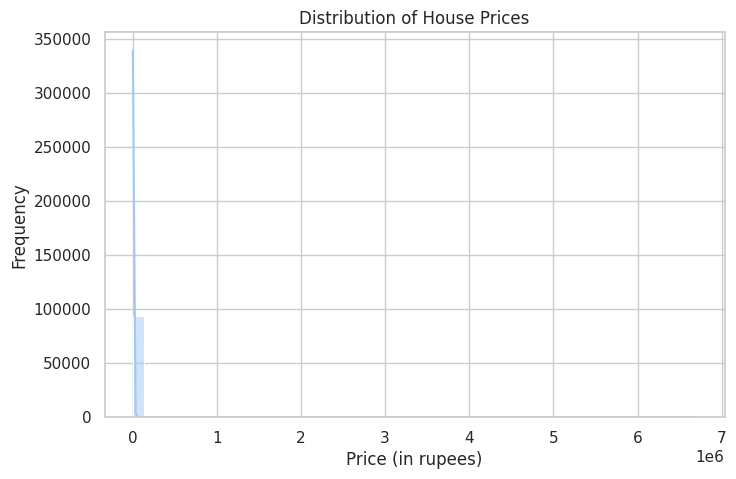

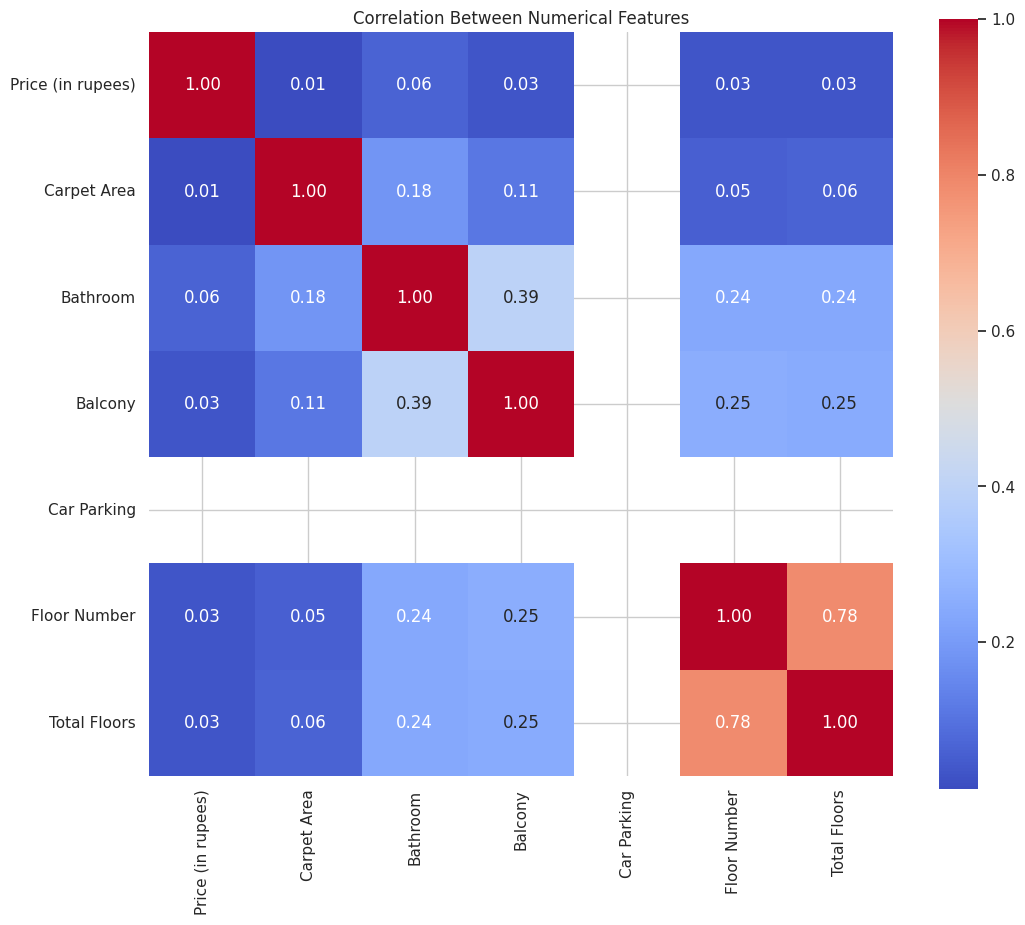

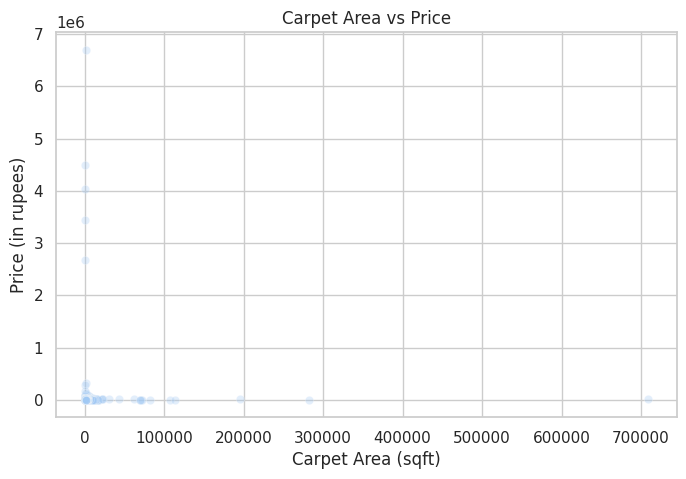

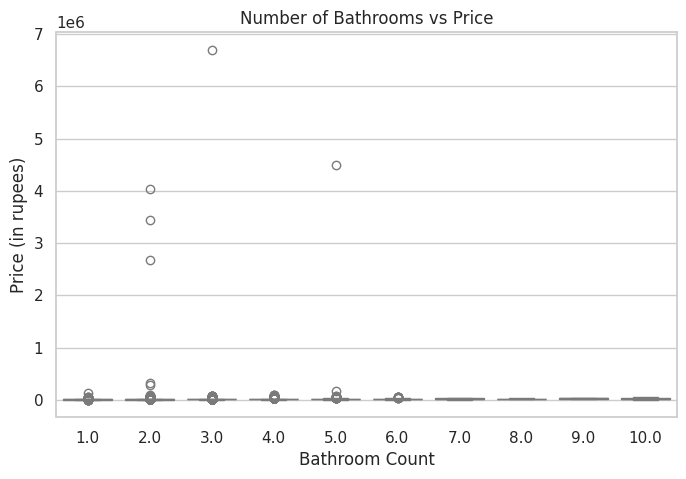

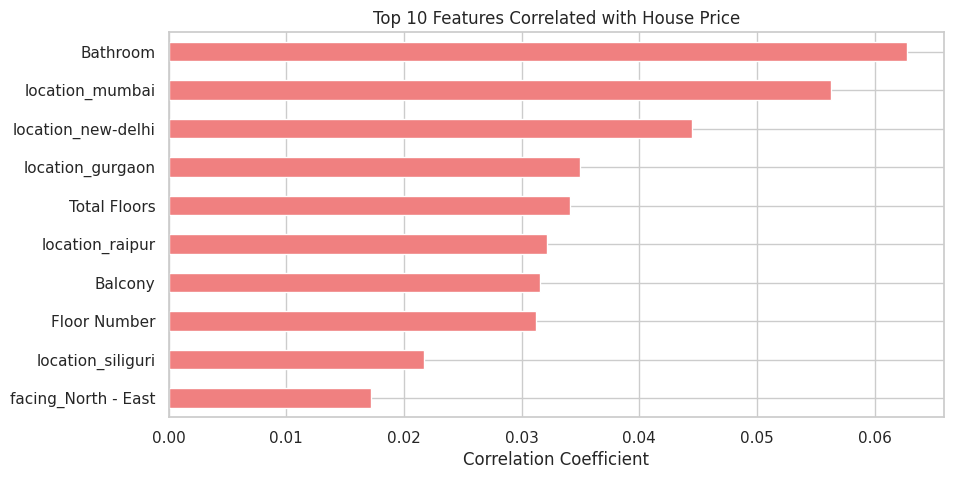

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set default style
sns.set(style="whitegrid", palette="pastel")

#  Histogram of Target Variable
plt.figure(figsize=(8,5))
sns.histplot(df_clean["Price (in rupees)"], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price (in rupees)")
plt.ylabel("Frequency")
plt.show()

#  Correlation Heatmap
plt.figure(figsize=(12,10))
num_features = df_clean.select_dtypes(include=["float64", "int64"]).corr()
sns.heatmap(num_features, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Between Numerical Features")
plt.show()

# Carpet Area vs Price
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean, x="Carpet Area", y="Price (in rupees)", alpha=0.3)
plt.title("Carpet Area vs Price")
plt.xlabel("Carpet Area (sqft)")
plt.ylabel("Price (in rupees)")
plt.show()

#  Bathroom Count vs Price
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x="Bathroom", y="Price (in rupees)")
plt.title("Number of Bathrooms vs Price")
plt.xlabel("Bathroom Count")
plt.ylabel("Price (in rupees)")
plt.show()

# Bar plot of top correlated features with price
corr_matrix = df_clean.corr(numeric_only=True)
price_corr = corr_matrix["Price (in rupees)"].sort_values(ascending=False).drop("Price (in rupees)").head(10)
plt.figure(figsize=(10, 5))
price_corr.plot(kind='barh', color='lightcoral')
plt.title("Top 10 Features Correlated with House Price")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.show()



# Step 3.1: Final Cleanup of DataFrame

# Drop 'Society' column — it's a non-informative identifier (like a building name)

In [5]:
# Drop 'Society' since it's just a name tag
df_clean = df_clean.drop(columns=["Society"])

# Fill remaining missing values (numeric)
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))




# Step 3.2: Rebuild Feature Matrix (X) and Target (y)

#  This block:
# - Prints all column names to inspect the dataset
# - Identifies and drops non-numeric (object/text) columns from features
# - Separates feature matrix (X) and target vector (y)
# - Confirms that X contains only numeric data for model compatibility


In [6]:
# Print all columns to spot issues
print("Columns in df_clean:", df_clean.columns.tolist())

# ✅ Drop all non-numeric columns
non_numeric_columns = df_clean.select_dtypes(include=['object']).columns.tolist()
print("Dropping these text columns from features:", non_numeric_columns)

# Drop object (text) columns + target column
X = df_clean.drop(columns=non_numeric_columns + ["Price (in rupees)"])
y = df_clean["Price (in rupees)"]

# Final confirmation: all numeric
print("Remaining feature columns:", X.columns.tolist())


Columns in df_clean: ['Title', 'Price (in rupees)', 'Carpet Area', 'Bathroom', 'Balcony', 'Car Parking', 'Floor Number', 'Total Floors', 'Transaction_Other', 'Transaction_Rent/Lease', 'Transaction_Resale', 'Furnishing_Semi-Furnished', 'Furnishing_Unfurnished', 'facing_North', 'facing_North - East', 'facing_North - West', 'facing_Not Provided', 'facing_South', 'facing_South - East', 'facing_South -West', 'facing_West', 'overlooking_Garden/Park, Main Road', 'overlooking_Garden/Park, Main Road, Pool', 'overlooking_Garden/Park, Not Available', 'overlooking_Garden/Park, Pool', 'overlooking_Garden/Park, Pool, Main Road', 'overlooking_Main Road', 'overlooking_Main Road, Garden/Park', 'overlooking_Main Road, Garden/Park, Pool', 'overlooking_Main Road, Not Available', 'overlooking_Main Road, Pool', 'overlooking_Main Road, Pool, Garden/Park', 'overlooking_Not Provided', 'overlooking_Pool', 'overlooking_Pool, Garden/Park', 'overlooking_Pool, Garden/Park, Main Road', 'overlooking_Pool, Main Road',

# Step 3.3: Fill All NaNs in Features
# -This step ensures the feature matrix (X) is clean before modeling.
# -Missing values in numeric columns are replaced with the median of each column.
# -This is a robust method that avoids introducing bias from extreme values.

In [7]:
# Fill any missing values in X using median (safe for numeric data)
X = X.fillna(X.median(numeric_only=True))



# Step 3.4: Prepare Features and Target for Modeling
# -Drop all non-numeric (text) columns, as regression models require numeric inputs.
#-Also drop the target column ('Price') from the features (X).
#-Fill missing values in the features using the column-wise median.
#-This helps maintain data consistency without introducing outliers.


In [8]:
# Step 1: Drop all non-numeric (text) columns and target
non_numeric_columns = df_clean.select_dtypes(include=['object']).columns.tolist()
X = df_clean.drop(columns=non_numeric_columns + ["Price (in rupees)"])
y = df_clean["Price (in rupees)"]

# Step 2: Fill missing values in X
X = X.fillna(X.median(numeric_only=True))



# Step 4: Model Training
# ✅ In this step, we train three regression models to predict house prices:
#    1. Linear Regression – baseline model for understanding linear relationships
#    2. Ridge Regression – a regularized version of linear regression to reduce overfitting
#    3. Polynomial Regression – captures non-linear relationships (trained on a smaller sample)
# ✅ Data is split into training and testing sets (80/20) for evaluation


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

# Polynomial Regression on smaller sample
X_poly_sample = X_train.sample(10000, random_state=42)
y_poly_sample = y_train.loc[X_poly_sample.index]
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_poly_sample, y_poly_sample)
poly_preds = poly_model.predict(X_test)



# Step 5: Model Evaluation

# ✅ This step evaluates the performance of each trained regression model using:
#    - Mean Absolute Error (MAE): Average absolute difference between actual and predicted values
#    - Mean Squared Error (MSE): Penalizes larger errors more than MAE
#    - Root Mean Squared Error (RMSE): Square root of MSE, same unit as target
# ✅ Helps compare which model performs best in predicting house prices


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} Evaluation:")
    print(f"  ➤ MAE  : {mae:,.2f}")
    print(f"  ➤ MSE  : {mse:,.2f}")
    print(f"  ➤ RMSE : {rmse:,.2f}\n")

evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Ridge Regression", y_test, ridge_preds)
evaluate_model("Polynomial Regression (Sampled)", y_test, poly_preds)


Linear Regression Evaluation:
  ➤ MAE  : 2,699.39
  ➤ MSE  : 886,907,481.35
  ➤ RMSE : 29,780.99

Ridge Regression Evaluation:
  ➤ MAE  : 2,681.37
  ➤ MSE  : 885,889,993.86
  ➤ RMSE : 29,763.90

Polynomial Regression (Sampled) Evaluation:
  ➤ MAE  : 2,235.81
  ➤ MSE  : 3,918,571,158.96
  ➤ RMSE : 62,598.49

